# **Projeto SCC0276 - Aprendizado de Máquina**

### ***Classificação de Imagens: Diagnóstico do Nível de Alzheimer***

#### **Nome**: Paulo Ricardo J. Miranda, **NUSP**: 10133456

#### **Nome**: Pedro Henrique Magalhães Cisdeli, **NUSP**: 10289804

# **Introdução** 



O presente projeto tem como objetivo classificar imagens de ressonância magnética digitais de acordo com rórulos pré-estabelecidos, ou seja, trata-se de uma classificação (aprendizado supervisionado).

A base utilizada para o projeto consiste de um total de 6.400 imagens de tamanhos 128x128, e pode ser obtida através do link: https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset. As imagens estão separadas por pastas cujo o nome é o rótulo das imagens ali contidas. Cada rótulo possui o seguinte nome com a respectiva quantidade de imagens:

- Classe - 1: *Mild Demented*, com 896 imagens
- Classe - 2: *Moderate Demented*, com 64 imagens
- Classe - 3: *Non Demented*, com 3200 imagens
- Classe - 4: *Very Mild Demented*, com 2240 imagens

#### **Modelos utilizados**

Para a tarefa de classificação, serão utilizados os modelos KNN, Árvore de Decisão, SVM, Redes Neurais e Redes Neurais Convolucionais.

Como o conjunto de dados é não estruturado (imagens), o problema requer uma forma de extrair descritores das imagens para serem utilizadas na Árvore de decisão e no KNN. Já as Redes Neurais e Redes Neurais Convolucionais, são mais "flexíveis" e, portanto, não necessitam que sejam feito esta extração.

#### **Métricas de avaliação**

O conjunto de dados conta com um desbalanceamento, contando com muitas imagens da classe *Non Demented* do que imagens com classe *Moderate Demented*, por exemplo. Por este motivo, é necessário utilizar a métrica correta para contornar o problema do desbalanceamento, uma vez que, não podemos utilizar técnicas de amostragem com este conjunto de dados. Assim, uma das métricas que serão utilizadas aqui são Acurácia e AUC (*Area Under Curve*).

# **Desenvolvimento:**

In [ ]:
# Fazer todos os imports das bibliotecas que serão necessárias no desenvolvimento
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axis import Axis 

# Import para ler as imagens .jpg e transformar em numpy.array
from skimage.io import imread, imread_collection
from skimage.feature import local_binary_pattern
from skimage.util import random_noise
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize, StandardScaler, Normalizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

from keras.metrics import AUC, Accuracy
from keras.models import Sequential, load_model, clone_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, InputLayer, Dropout
import keras.utils.np_utils as kutils

# Import para utilizar o Google Drive
from google.colab import drive

#### **Utilizando o *Google Drive*:**

Como irá ser utilizado o Google Drive para armazenar a base de imagens, primeiramente, necessita-se montar o Google Drive para acessar a pasta do projeto:

In [ ]:
# Essa linha, monta o drive do Google Drive na pasta drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Dentro da pasta *drive*, existe uma pasta chamada *MyDrive*, na qual é a raiz do Google Drive a ser utilizado. Logo:

In [ ]:
!ls drive/MyDrive/MachineLearning/project

alzheimer_mri_data.zip	projeto.ipynb


Criando uma variável com o caminho do projeto para facilitar algumas operações:

In [ ]:
PROJECT_PATH = 'drive/MyDrive/MachineLearning/project/'

Extraindo do arquivo .zip a pasta com as imagens:

In [ ]:
%%time

!unzip -qq $PROJECT_PATH/alzheimer_mri_data.zip

CPU times: user 14.2 ms, sys: 9.06 ms, total: 23.3 ms
Wall time: 1.62 s


### **Carregando as imagens**:

Para carregar as imagens, será utilizada a biblioteca *skimage*. 

Como as imagens estão agrupadas em pastas separadas pelo rótulo e não possuem um certo tipo de padrão nos nomes dos arquivos das imagens necessita-se de alguma função que facilite carregá-las. Felizmente, o *skimage* facilita este tipo de processo utilizando a classe *ImageCollection* e o método *imread_collection*.

O método *imread_collection* recebe como um de seus parâmetros um padrão. Logo, podemos passar o caminho da imagem seguido do caractere "*" mais a extensão. Exemplo:

```
imread_collection('caminho_das_imagens/*.jpg')
```


Ele retorna um *ImageCollection* no qual é uma estrutura que conterá todas as imagens "carregadas". Basta fazer:
```
collection = imread_collection('caminho_das_imagens/*.jpg')
collection[0]
```

Acessando o índice da estrutura, lhe retornará a matriz com os pixels da imagem.

Carregando as imagens de cada classe:

Função para converter uma *ImageCollection* em uma matriz:

In [ ]:
def convert_image_collection_to_2d_array(image_collection):
  IMAGES_WIDTH = 128
  IMAGES_HEIGHT = 128
  NUMBER_OF_IMAGES = len(image_collection)

  image_dataset = np.zeros((NUMBER_OF_IMAGES, IMAGES_WIDTH, IMAGES_HEIGHT))

  for i in range(0, NUMBER_OF_IMAGES):
    image_dataset[i] = (image_collection[i])

  return image_dataset

- *Non Demented*:

In [ ]:
# Cria um ImageCollection com as imagens da pasta Non_Demented
non_demented_image_collection = imread_collection('Dataset/Non_Demented/*.jpg')

non_demented_images = convert_image_collection_to_2d_array(non_demented_image_collection)

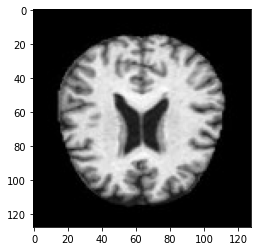

In [ ]:
plt.imshow(non_demented_images[0], cmap='gray')

- *Very Mild Demented*:

In [ ]:
# Cria um ImageCollection com as imagens da pasta Very_Mild_Demented
very_mild_demented_image_collection = imread_collection('Dataset/Very_Mild_Demented/*.jpg')

very_mild_demented_images = convert_image_collection_to_2d_array(very_mild_demented_image_collection)

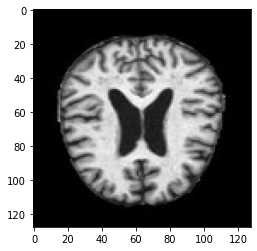

In [ ]:
plt.imshow(very_mild_demented_images[0], cmap='gray')

- *Mild Demented*:

In [ ]:
# Cria um ImageCollection com as imagens da pasta Mild_Demented
mild_demented_image_collection = imread_collection('Dataset/Mild_Demented/*.jpg')

mild_demented_images = convert_image_collection_to_2d_array(mild_demented_image_collection)

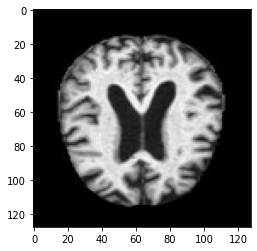

In [ ]:
plt.imshow(mild_demented_images[0], cmap='gray')

- *Moderate Demented*:

In [ ]:
# Cria um ImageCollection com as imagens da pasta Moderated_Demented
moderate_demented_image_collection = imread_collection('Dataset/Moderate_Demented/*.jpg')

moderate_demented_images = convert_image_collection_to_2d_array(moderate_demented_image_collection)

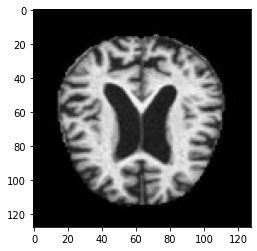

In [ ]:
plt.imshow(moderate_demented_images[0], cmap='gray')

Após carregarmos as imagens de cada categoria, é preciso criar *arrays* com os rótulos de cada classe. Assim, define-se os rótulos de cada classe como sendo:

- *Non Demented* = 0
- *Very Mild Demented* = 1
- *Mild Demented* = 2
- *Moderate Demented* = 3

In [ ]:
y_non_demented = np.repeat(0, len(non_demented_image_collection))

y_non_demented.shape[0], len(non_demented_image_collection)

(3200, 3200)

In [ ]:
y_very_mild_demented = np.repeat(1, len(very_mild_demented_image_collection))

y_very_mild_demented.shape[0], len(very_mild_demented_image_collection)

(2240, 2240)

In [ ]:
y_mild_demented = np.repeat(2, len(mild_demented_image_collection))

y_mild_demented.shape[0], len(mild_demented_image_collection)

(896, 896)

In [ ]:
y_moderate_demented = np.repeat(3, len(moderate_demented_image_collection))

y_moderate_demented.shape[0], len(moderate_demented_image_collection)

(64, 64)

Concatenando as listas de matrizes das imagens:

In [ ]:
dataset_images = np.concatenate((
    non_demented_images,
    very_mild_demented_images,
    mild_demented_images,
    moderate_demented_images
))

Transformando os pixels das imagens para o intervalor [0, 1]:

In [ ]:
dataset_images = np.float16(dataset_images / dataset_images.max())

In [ ]:
dataset_images.shape

(6400, 128, 128)

Concatenando os rótulos:

In [ ]:
y = np.concatenate((
    y_non_demented,
    y_very_mild_demented,
    y_mild_demented,
    y_moderate_demented
))

In [ ]:
y.shape

(6400,)

Embaralhando os dados:

In [ ]:
dataset_images, y = shuffle(dataset_images, y, random_state=42)

Verificando a distribuição de cada uma das classes:

[]

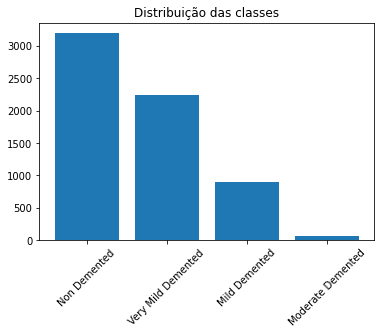

In [ ]:
_, classes_freq = np.unique(y, return_counts=True)

plt.title("Distribuição das classes")
plt.bar(x=['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented'], height=classes_freq)
plt.xticks(rotation=45)
plt.plot()

### **Modelagem**:

#### **Pré-processamento**:

Função para calcular o *Local Binary Pattern* das imagens de treino e teste para serem utilizadas no *KNN* e *Decision Tree*:

In [ ]:
def calculate_lbp_and_histogram(images):
  data = []
  for image in images:
    # Calcula o descritor 'Local Binary Pattern' da imagem 'image'
    lbp_descriptor = local_binary_pattern(image, P=8, R=1, method='uniform')
    # Calcula o histograma normalizado
    normalized_histogram, _ = np.histogram(lbp_descriptor, density=True)

    data.append(normalized_histogram)

  return data

Testando o *Local Binary Pattern* em uma imagem da base:

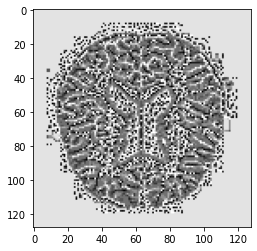

In [ ]:
lbp = local_binary_pattern(dataset_images[1], P=8, R=1, method='uniform')

plt.imshow(lbp, cmap='gray')

#### **Dividindo o conjunto de dados**

Serão criados 6 conjuntos de dados:
- Treino e teste com imagens sem ruído;
- Treino e teste com imagens com ruído (em 0,01);
- Treino e teste com imagens com ruído (em 0,001;


In [ ]:
# Na linha abaixo, dividiremos o conjunto de dados em 40% para teste e 60% para treino.
# Como há desbalanceamento das classes, é necessário manter a proporção dos classes nos dois conjuntos (teste e treino)
# Felizmente, o train_test_split, caso o argumento passado para 'stratify' seja 'None', ele manterá a proporção das classes

X_train, X_test, y_train, y_test = train_test_split(dataset_images, y, test_size=0.4, random_state=42)

Distribuição das classes de treino e teste:

[]

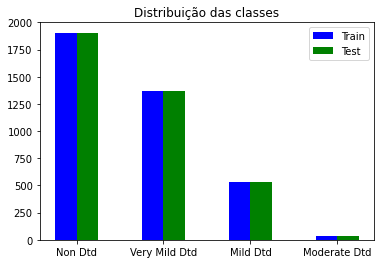

In [ ]:
_, train_freq = np.unique(y_train, return_counts=True)
_, test_freq = np.unique(y_train, return_counts=True)
x=['Non Dtd', 'Very Mild Dtd', 'Mild Dtd', 'Moderate Dtd']
n = len(x)
r = np.arange(n)
width = 0.25

plt.title("Distribuição das classes")
plt.bar(r, train_freq, color = 'b', width = width, label = 'Train')
plt.bar(r + width, test_freq, color = 'g', width = width, label = 'Test')
plt.xticks(r + width / 2, x)

plt.legend()
plt.plot()

As imagens do conjunto de dados não possuem variações "significantes", o que pode prejudicar a generalização do modelo. Uma maneira de contornar este problema, é criando variações das próprias imagens do conjunto de dados. 

Assim, no presente projeto, criaremos dois conjuntos de dados, cuja as imagens irão conter uma determinada quantidade de ruídos. Essa quantidade será determinada, de maneira aleatória, pela distribuição Gaussiana.

In [ ]:
# Conjunto de imagens (treino e teste) com ruído de 0,01 e e o descritor local binary pattern:
X_train_noisy_001 = np.float16(random_noise(X_train, mode='gaussian', var=0.01))
X_test_noisy_001 = np.float16(random_noise(X_test, mode='gaussian', var=0.01))

# Conjunto de imagens (treino e teste) com ruído de 0,001 e o descritor local binary pattern:
X_train_noisy_0001 = np.float16(random_noise(X_train, mode='gaussian', var=0.001))
X_test_noisy_0001 = np.float16(random_noise(X_test, mode='gaussian', var=0.001))

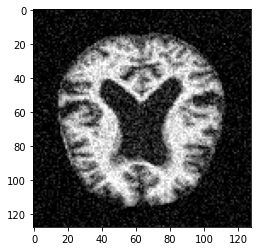

In [ ]:
plt.imshow(np.float32(X_train_noisy_001[0]), cmap='gray')

Calculando o *Local Binary Pattern* para cada conjunto de dados:

- Sem ruído:

In [ ]:
X_train_lbp = calculate_lbp_and_histogram(X_train)
X_test_lbp = calculate_lbp_and_histogram(X_test)


- Com ruído (0,01):

In [ ]:
X_train_lbp_noisy_001 = calculate_lbp_and_histogram(X_train_noisy_001)
X_test_lbp_noisy_001 = calculate_lbp_and_histogram(X_test_noisy_001)

- Com ruído (0,001):

In [ ]:
X_train_lbp_noisy_0001 = calculate_lbp_and_histogram(X_train_noisy_0001)
X_test_lbp_noisy_0001 = calculate_lbp_and_histogram(X_test_noisy_0001)

#### **Avaliação dos modelos**:

Na célula abaixo, serão criadas variáveis auxiliares para ajudarem na avaliação do modelo:

In [ ]:
# Valor a ser utilizado no argumento 'cv' do GridSearchCV 
stratified_k_fold_value = 5

# Vetor com os dados com descritores 'Local Binary Pattern' de teste
X_tests_lbp = [X_test_lbp, X_test_lbp_noisy_001, X_test_lbp_noisy_0001]

# Função que retorna um DataFrame com o resumo da avaliação do 'estimator' nos conjuntos de dados 'X_tests'
# O DataFrame contém as métricas: acurácia e AUC
def multiclass_classification_report(estimator, X_tests, y_true):
  row_labels = ['Acurácia', 'AUC']
  column_labels = ['Imagens sem ruído', 'Imagens com ruído (0,01)', 'Imagens com ruído (0,001)']
  
  acc_scores = []
  auc_scores = []

  y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

  for X_test in X_tests:
    y_pred = estimator.predict(X_test)
    y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2, 3])

    acc_scores.append(accuracy_score(y_true, y_pred))
    auc_scores.append(roc_auc_score(y_true_bin, y_pred_bin))
  
  model_performance_df = pd.DataFrame(data=[acc_scores, auc_scores], index=row_labels, columns=column_labels)

  return model_performance_df

##### **KNN**

Hiperparâmetros do KNN para serem treinados e testados:

In [ ]:
knn_hiperparams = {
    'n_neighbors': [1, 3, 5, 7, 13, 23],
    'p': [1, 2, 3]
}

O ***Grid Search Cross Validadtion*** (*GridSearchCV*) é uma maneira de realizar o treinamento e avaliação de um modelo com as combinações de hiperparâmetros passados no argumento "*param_grid*".

Ainda, será utilizado o *Stratified KFold Cross Validation*, com *k = 5* no *Grid Search*.

Serão criados 3 modelos:
- Um será treinado com imagens sem ruído;
- O segundo treinado com imagens com ruído (de 0,01);
- O terceiro treinado com imagens com ruído (de 0,001);

In [ ]:
grid_search_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_hiperparams,
    cv=stratified_k_fold_value
)

grid_search_knn_noisy_001 = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_hiperparams,
    cv=stratified_k_fold_value
)

grid_search_knn_noisy_0001 = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_hiperparams,
    cv=stratified_k_fold_value
)

###### **Treinamento**

Treinando o KNN utilizando as imagens, com o *Local Binary Pattern* calculado e sem ruído, e com os hiperparâmetros definidos na variável "*knn_hiperparams*".

In [ ]:
grid_search_knn.fit(X=X_train_lbp, y=y_train)

# Melhor KNN treinado com imagens sem ruído:
best_knn = grid_search_knn.best_estimator_

best_knn

KNeighborsClassifier(n_neighbors=23, p=1)

Treinando o KNN utilizando as imagens, com o *Local Binary Pattern* calculado e com ruído (0,01), e com os hiperparâmetros definidos na variável "*knn_hiperparams*".

In [ ]:
grid_search_knn_noisy_001.fit(X=X_train_lbp_noisy_001, y=y_train)

# Melhor KNN treinado com imagens com ruído de 0,01:
best_knn_noisy_001 = grid_search_knn_noisy_001.best_estimator_

best_knn_noisy_001

KNeighborsClassifier(n_neighbors=23)

Treinando o KNN utilizando as imagens, com o *Local Binary Pattern* calculado e com ruído (0,001), e com os hiperparâmetros definidos na variável "*knn_hiperparams*".

In [ ]:
grid_search_knn_noisy_0001.fit(X=X_train_lbp_noisy_0001, y=y_train)

# Melhor KNN treinado com imagens com ruído de 0,001:
best_knn_noisy_0001 = grid_search_knn_noisy_0001.best_estimator_

best_knn_noisy_0001

KNeighborsClassifier(n_neighbors=23, p=3)

###### **Avaliação (teste)**

Vamos utilizar os melhores KNNs para avaliar os modelos nos dados de teste:

- KNN treinado com imagens sem ruído:

In [ ]:
df_knn = multiclass_classification_report(best_knn, X_tests_lbp, y_test)
df_knn

,Imagens sem ruído,"Imagens com ruído (0,01)","Imagens com ruído (0,001)"
Acurácia,0.530078,0.339453,0.346484
AUC,0.539670,0.500000,0.501450


- KNN treinado com imagens com ruído de 0,01:

In [ ]:
df_knn_001 = multiclass_classification_report(best_knn_noisy_001, X_tests_lbp, y_test)
df_knn_001

,Imagens sem ruído,"Imagens com ruído (0,01)","Imagens com ruído (0,001)"
Acurácia,0.255469,0.510156,0.505859
AUC,0.506845,0.532320,0.500000


- KNN treinado com imagens com ruído de 0,001:

In [ ]:
df_knn_0001 = multiclass_classification_report(best_knn_noisy_0001, X_tests_lbp, y_test)
df_knn_0001

,Imagens sem ruído,"Imagens com ruído (0,01)","Imagens com ruído (0,001)"
Acurácia,0.344141,0.339453,0.510547
AUC,0.499625,0.500000,0.528289


##### **Árvore de Decisão**

Hiperparâmetros da Árvore de Decisão para serem treinados e testados:

In [ ]:
decision_tree_hiperparams = {
    'splitter': ['best', 'random'],
    'max_depth': [2, 4, 5, 8, 10],
    'max_leaf_nodes': [2, 4, 6, 8, 10, 20]
}

In [ ]:
grid_search_decision_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=decision_tree_hiperparams,
    cv=stratified_k_fold_value
)

grid_search_decision_tree_noisy_001 = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=decision_tree_hiperparams,
    cv=stratified_k_fold_value
)

grid_search_decision_tree_noisy_0001 = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=decision_tree_hiperparams,
    cv=stratified_k_fold_value
)

###### **Treinamento**

Treinando a Árvore de Decisão utilizando as imagens, com o *Local Binary Pattern* e sem ruído, e com os hiperparâmetros definidos na variável "*decision_tree_hiperparams*":



In [ ]:
grid_search_decision_tree.fit(X=X_train_lbp, y=y_train)

best_decision_tree = grid_search_decision_tree.best_estimator_

best_decision_tree

DecisionTreeClassifier(max_depth=8, max_leaf_nodes=10, random_state=42)

Treinando a Árvore de Decisão utilizando as imagens, com o *Local Binary Pattern* e com ruído (0,01), e com os hiperparâmetros definidos na variável "*decision_tree_hiperparams*":



In [ ]:
grid_search_decision_tree_noisy_001.fit(X=X_train_lbp_noisy_001, y=y_train)

best_decision_tree_noisy_001 = grid_search_decision_tree_noisy_001.best_estimator_

best_decision_tree_noisy_001

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=6, random_state=42,
                       splitter='random')

Treinando a Árvore de Decisão utilizando as imagens, com o *Local Binary Pattern* e com ruído (0,001), e com os hiperparâmetros definidos na variável "*decision_tree_hiperparams*":



In [ ]:
grid_search_decision_tree_noisy_0001.fit(X=X_train_lbp_noisy_0001, y=y_train)

best_decision_tree_noisy_0001 = grid_search_decision_tree_noisy_0001.best_estimator_

best_decision_tree_noisy_0001

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=8, random_state=42,
                       splitter='random')

###### **Avaliação (teste):**

Vamos utilizar as melhores Árvores de Decisão para avaliar os modelos em cada um dos dados de teste:

- Árvore de Decisão treinada com imagens sem ruído:




In [ ]:
df_dt = multiclass_classification_report(best_decision_tree, X_tests_lbp, y_test)
df_dt

,Imagens sem ruído,"Imagens com ruído (0,01)","Imagens com ruído (0,001)"
Acurácia,0.512109,0.339453,0.366797
AUC,0.538356,0.500000,0.482503


- Árvore de Decisão treinada com imagens com ruído de 0,01:

In [ ]:
df_dt_001 = multiclass_classification_report(best_decision_tree_noisy_001, X_tests_lbp, y_test)
df_dt_001

,Imagens sem ruído,"Imagens com ruído (0,01)","Imagens com ruído (0,001)"
Acurácia,0.339453,0.514844,0.339453
AUC,0.500000,0.528528,0.500000


- Árvore de Decisão treinada com imagens com ruído de 0,001:

In [ ]:
df_dt_0001 = multiclass_classification_report(best_decision_tree_noisy_0001, X_tests_lbp, y_test)
df_dt_0001

,Imagens sem ruído,"Imagens com ruído (0,01)","Imagens com ruído (0,001)"
Acurácia,0.340234,0.505859,0.501172
AUC,0.500269,0.500000,0.507593


##### **HOG-SVM**


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog
import skimage

# Class author: Patrick Steegstra, https://kapernikov.com/tutorial-image-classification-with-scikit-learn/
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [ ]:
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()

Pré processamento dos dados de treino e teste

- Sem ruído:

In [ ]:
X_train_SVM = hogify.fit_transform(X_train)
X_train_SVM = scalify.fit_transform(X_train_SVM)

X_test_SVM = hogify.fit_transform(X_test)
X_test_SVM = scalify.fit_transform(X_test_SVM)

- Com ruído (0,01):

In [ ]:
X_train_SVM_001 = hogify.fit_transform(X_train_noisy_001)
X_train_SVM_001 = scalify.fit_transform(X_train_SVM_001)

X_test_SVM_001 = hogify.fit_transform(X_test_noisy_001)
X_test_SVM_001 = scalify.fit_transform(X_test_SVM_001)

- Com ruído (0,001):

In [ ]:
X_train_SVM_0001 = hogify.fit_transform(X_train_noisy_0001)
X_train_SVM_0001 = scalify.fit_transform(X_train_SVM_0001)

X_test_SVM_0001 = hogify.fit_transform(X_test_noisy_0001)
X_test_SVM_0001 = scalify.fit_transform(X_test_SVM_0001)

###### **Treinamento**

- Sem ruído:

In [ ]:
sgd = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd.fit(X_train_SVM, y_train)

SGDClassifier(random_state=42)

- Com ruído (0,01):

In [ ]:
sgd_001 = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_001.fit(X_train_SVM_001, y_train)

SGDClassifier(random_state=42)

- Com ruído (0,001):

In [ ]:
sgd_0001 = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_0001.fit(X_train_SVM_0001, y_train)

SGDClassifier(random_state=42)

###### **Avaliação (teste)**

In [ ]:
# Vetor com os dados com descritores 'Local Binary Pattern' de teste
X_tests_SVM = [X_test_SVM, X_test_SVM_001, X_test_SVM_0001]

- HOG-SVM treinada com imagens sem ruído:

In [ ]:
df_svm = multiclass_classification_report(sgd, X_tests_SVM, y_test)
df_svm

,Imagens sem ruído,"Imagens com ruído (0,01)","Imagens com ruído (0,001)"
Acurácia,0.701562,0.557422,0.651953
AUC,0.692319,0.584891,0.677489


- HOG-SVM treinada com imagens com ruído de 0,01:

In [ ]:
df_svm_001 = multiclass_classification_report(sgd_001, X_tests_SVM, y_test)
df_svm_001

,Imagens sem ruído,"Imagens com ruído (0,01)","Imagens com ruído (0,001)"
Acurácia,0.588672,0.559766,0.576562
AUC,0.622539,0.599451,0.629814


- HOG-SVM treinada com imagens com ruído de 0,001:

In [ ]:
df_svm_0001 = multiclass_classification_report(sgd_0001, X_tests_SVM, y_test)
df_svm_0001

,Imagens sem ruído,"Imagens com ruído (0,01)","Imagens com ruído (0,001)"
Acurácia,0.662109,0.581641,0.656250
AUC,0.673408,0.604085,0.679372


##### **Rede Neural**

Primeiramente, vamos transformar as matrizes (sem ruído, com ruído de 0,01 e com ruído de 0,001) de treino em vetores de com 16.384 posições:

In [ ]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH  = 128

X_train_mlp = np.reshape(X_train, (X_train.shape[0], IMAGE_HEIGHT * IMAGE_WIDTH))

X_train_mlp_noisy_001 = np.reshape(X_train_noisy_001, (X_train_noisy_001.shape[0], IMAGE_HEIGHT * IMAGE_WIDTH))

X_train_mlp_noisy_0001 = np.reshape(X_train_noisy_0001, (X_train_noisy_001.shape[0], IMAGE_HEIGHT * IMAGE_WIDTH))

Fazendo a mesma coisa com as matrizes de teste:

In [ ]:
X_test_mlp = np.reshape(X_test, (X_test.shape[0], IMAGE_HEIGHT * IMAGE_WIDTH))

X_test_mlp_noisy_001 = np.reshape(X_test_noisy_001, (X_test_noisy_001.shape[0], IMAGE_HEIGHT * IMAGE_WIDTH))

X_test_mlp_noisy_0001 = np.reshape(X_test_noisy_0001, (X_test_noisy_001.shape[0], IMAGE_HEIGHT * IMAGE_WIDTH))

In [ ]:
mlp_hiperparams = {
    'hidden_layer_sizes': [(5, 3, 2, 4), (5, 5, 4), (10, 6, 4)],
    'max_iter': [100]
}

In [ ]:
grid_search_mlp = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid=mlp_hiperparams,
    cv=stratified_k_fold_value
)

grid_search_mlp_noisy_001 = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid=mlp_hiperparams,
    cv=stratified_k_fold_value
)

grid_search_mlp_noisy_0001 = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid=mlp_hiperparams,
    cv=stratified_k_fold_value
)

###### **Treinamento**

Treinando a Rede Neural utilizando as imagens sem ruído, e com os hiperparâmetros definidos na variável "*mlp_hiperparams*":

In [ ]:
grid_search_mlp.fit(X=X_train_mlp, y=y_train)

best_mlp = grid_search_mlp.best_estimator_

best_mlp

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

MLPClassifier(hidden_layer_sizes=(5, 5, 4), max_iter=100, random_state=42)

Treinando a Rede Neural utilizando as imagens com ruído (0,01), e com os hiperparâmetros definidos na variável "*mlp_hiperparams*":

In [ ]:
grid_search_mlp.fit(X=X_train_mlp_noisy_001, y=y_train)

best_mlp_noisy_001 = grid_search_mlp.best_estimator_

best_mlp_noisy_001

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

MLPClassifier(hidden_layer_sizes=(10, 6, 4), max_iter=100, random_state=42)

Treinando a Rede Neural utilizando as imagens com ruído (0,001), e com os hiperparâmetros definidos na variável "*mlp_hiperparams*":

In [ ]:
grid_search_mlp.fit(X=X_train_mlp_noisy_0001, y=y_train)

best_mlp_noisy_0001 = grid_search_mlp.best_estimator_

best_mlp_noisy_0001

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

MLPClassifier(hidden_layer_sizes=(5, 5, 4), max_iter=100, random_state=42)

###### **Avaliação (teste)**

In [ ]:
# Vetor com todos os conjuntos de dados que serão utilizados para teste da rede neural
X_tests_mlp = [X_test_mlp, X_test_mlp_noisy_001, X_test_mlp_noisy_0001]

- Rede Neural treinada com imagens sem ruído:

In [ ]:
df_mlp = multiclass_classification_report(best_mlp, X_tests_mlp, y_test)
df_mlp

,Imagens sem ruído,"Imagens com ruído (0,01)","Imagens com ruído (0,001)"
Acurácia,0.713281,0.612891,0.691016
AUC,0.712520,0.673264,0.706592


- Rede Neural treinada com imagens com ruído de 0,01:

In [ ]:
df_mlp_001 = multiclass_classification_report(best_mlp_noisy_001, X_tests_mlp, y_test)
df_mlp_001

,Imagens sem ruído,"Imagens com ruído (0,01)","Imagens com ruído (0,001)"
Acurácia,0.560937,0.677344,0.622266
AUC,0.543023,0.672685,0.589439


- Rede Neural treinada com imagens com ruído de 0,001:

In [ ]:
df_mlp_0001 = multiclass_classification_report(best_mlp_noisy_0001, X_tests_mlp, y_test)
df_mlp_0001

,Imagens sem ruído,"Imagens com ruído (0,01)","Imagens com ruído (0,001)"
Acurácia,0.723047,0.516797,0.757422
AUC,0.667107,0.636789,0.712451


## **Parte 3**

In [ ]:
# Função que retorna um DataFrame com o resumo da avaliação da 'CNN' nos conjuntos de dados 'X_tests'
# O DataFrame contém as métricas: acurácia e AUC
def cnn_multiclass_classification_report(cnn, X_tests, y_true):
  row_labels = ['Acurácia', 'AUC']
  column_labels = ['Imagens sem ruído', 'Imagens com ruído (0,01)', 'Imagens com ruído (0,001)']
  
  acc_scores = []
  auc_scores = []

  for X_test in X_tests:
    loss, accuracy, auc = cnn.evaluate(x=X_test, y=y_true, verbose=0)

    acc_scores.append(accuracy)
    auc_scores.append(auc)
  
  model_performance_df = pd.DataFrame(data=[acc_scores, auc_scores], index=row_labels, columns=column_labels)

  return model_performance_df

In [ ]:
X_tests = [X_test, X_test_noisy_001, X_test_noisy_0001]

##### **CNN**

Criando o modelo (descrito no artigo: https://ieeexplore.ieee.org/document/9215402):

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(128, 128, 1)))
model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(4, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                                 
 dense (Dense)               (None, 4)                 1048580   
                                                        

Convertendo os rótulo em *One Hot Encoding*:

In [ ]:
cnn_y_train = kutils.to_categorical(y_train, num_classes=4)
cnn_y_test = kutils.to_categorical(y_test, num_classes=4)

- Treinando o modelo com o conjunto de imagens sem ruído:

In [ ]:
cnn = clone_model(model)

cnn.compile(
    optimizer='adam',
    metrics=['accuracy', AUC()],
    loss='categorical_crossentropy'
)

cnn.fit(x=X_train, y=cnn_y_train, epochs=10, verbose=1)

Epoch 1/10
120/120 [==============================] - 17s 30ms/step - loss: 1.0585 - accuracy: 0.4927 - auc: 0.7870
Epoch 2/10
120/120 [==============================] - 4s 30ms/step - loss: 0.8625 - accuracy: 0.5966 - auc: 0.8522
Epoch 3/10
120/120 [==============================] - 4s 30ms/step - loss: 0.5823 - accuracy: 0.7505 - auc: 0.9267
Epoch 4/10
120/120 [==============================] - 4s 30ms/step - loss: 0.3249 - accuracy: 0.8737 - auc: 0.9667
Epoch 5/10
120/120 [==============================] - 4s 30ms/step - loss: 0.1619 - accuracy: 0.9471 - auc: 0.9847
Epoch 6/10
120/120 [==============================] - 4s 31ms/step - loss: 0.0761 - accuracy: 0.9797 - auc: 0.9932
Epoch 7/10
120/120 [==============================] - 4s 31ms/step - loss: 0.0380 - accuracy: 0.9898 - auc: 0.9962
Epoch 8/10
120/120 [==============================] - 4s 31ms/step - loss: 0.0297 - accuracy: 0.9919 - auc: 0.9969
Epoch 9/10
120/120 [==============================] - 4s 31ms/step - loss: 0.02

In [ ]:
df_cnn = cnn_multiclass_classification_report(cnn, X_tests, cnn_y_test)
df_cnn

,Imagens sem ruído,"Imagens com ruído (0,01)","Imagens com ruído (0,001)"
Acurácia,0.963672,0.820703,0.950391
AUC,0.984866,0.907450,0.981045


- Treinando o modelo com o conjunto de imagens com ruído (0,01):

In [ ]:
cnn_noisy_001 = clone_model(model)

cnn_noisy_001.compile(
    optimizer='adam',
    metrics=['accuracy', AUC()],
    loss='categorical_crossentropy'
)

cnn_noisy_001.fit(x=X_train, y=cnn_y_train, epochs=10, verbose=1)

Epoch 1/10
120/120 [==============================] - 4s 31ms/step - loss: 1.0465 - accuracy: 0.5049 - auc_1: 0.7892
Epoch 2/10
120/120 [==============================] - 4s 31ms/step - loss: 0.8372 - accuracy: 0.6237 - auc_1: 0.8472
Epoch 3/10
120/120 [==============================] - 4s 31ms/step - loss: 0.5178 - accuracy: 0.7836 - auc_1: 0.9186
Epoch 4/10
120/120 [==============================] - 4s 31ms/step - loss: 0.2398 - accuracy: 0.9156 - auc_1: 0.9717
Epoch 5/10
120/120 [==============================] - 4s 31ms/step - loss: 0.1181 - accuracy: 0.9654 - auc_1: 0.9798
Epoch 6/10
120/120 [==============================] - 4s 31ms/step - loss: 0.0695 - accuracy: 0.9805 - auc_1: 0.9736
Epoch 7/10
120/120 [==============================] - 4s 31ms/step - loss: 0.0455 - accuracy: 0.9883 - auc_1: 0.9695
Epoch 8/10
120/120 [==============================] - 4s 31ms/step - loss: 0.0256 - accuracy: 0.9948 - auc_1: 0.9676
Epoch 9/10
120/120 [==============================] - 4s 31ms/st

In [ ]:
df_cnn_001 = cnn_multiclass_classification_report(cnn_noisy_001, X_tests, cnn_y_test)
df_cnn_001

,Imagens sem ruído,"Imagens com ruído (0,01)","Imagens com ruído (0,001)"
Acurácia,0.964063,0.926953,0.960547
AUC,0.932558,0.812616,0.923108


- Treinamento com o conjunto de imagens com ruído (0,001):

In [ ]:
cnn_noisy_0001 = clone_model(model)

cnn_noisy_0001.compile(
    optimizer='adam',
    metrics=['accuracy', AUC()],
    loss='categorical_crossentropy'
)

cnn_noisy_0001.fit(x=X_train, y=cnn_y_train, epochs=10, verbose=1)

Epoch 1/10
120/120 [==============================] - 4s 31ms/step - loss: 1.0664 - accuracy: 0.5065 - auc_2: 0.7846
Epoch 2/10
120/120 [==============================] - 4s 31ms/step - loss: 0.8589 - accuracy: 0.5969 - auc_2: 0.8533
Epoch 3/10
120/120 [==============================] - 4s 31ms/step - loss: 0.5479 - accuracy: 0.7719 - auc_2: 0.9339
Epoch 4/10
120/120 [==============================] - 4s 32ms/step - loss: 0.3258 - accuracy: 0.8792 - auc_2: 0.9697
Epoch 5/10
120/120 [==============================] - 4s 31ms/step - loss: 0.2011 - accuracy: 0.9289 - auc_2: 0.9842
Epoch 6/10
120/120 [==============================] - 4s 31ms/step - loss: 0.1298 - accuracy: 0.9547 - auc_2: 0.9897
Epoch 7/10
120/120 [==============================] - 4s 32ms/step - loss: 0.0790 - accuracy: 0.9721 - auc_2: 0.9937
Epoch 8/10
120/120 [==============================] - 4s 32ms/step - loss: 0.0443 - accuracy: 0.9885 - auc_2: 0.9960
Epoch 9/10
120/120 [==============================] - 4s 32ms/st

In [ ]:
df_cnn_0001 = cnn_multiclass_classification_report(cnn_noisy_0001, X_tests, cnn_y_test)
df_cnn_0001

,Imagens sem ruído,"Imagens com ruído (0,01)","Imagens com ruído (0,001)"
Acurácia,0.958594,0.911719,0.955859
AUC,0.988495,0.977624,0.987585


# **Conclusão** 


##### **Prepação dos dados de desempenho gerais**

Preparando os dataframes para a visualização dos dados obtidos utilizando a acurácia de cada modelo.

In [ ]:
drop_index = 'AUC'

# KNN
df_knn = df_knn.drop(drop_index, axis=0)
df_knn = df_knn.rename({'Acurácia':'KNN'}, axis=0)

df_knn_001 = df_knn_001.drop(drop_index, axis=0)
df_knn_001 = df_knn_001.rename({'Acurácia':'KNN_001'}, axis=0)

df_knn_0001 = df_knn_0001.drop(drop_index, axis=0)
df_knn_0001 = df_knn_0001.rename({'Acurácia':'KNN_0001'}, axis=0)

# Decision Tree
df_dt = df_dt.drop(drop_index, axis=0)
df_dt = df_dt.rename({'Acurácia':'DT'}, axis=0)

df_dt_001 = df_dt_001.drop(drop_index, axis=0)
df_dt_001 = df_dt_001.rename({'Acurácia':'DT_001'}, axis=0)

df_dt_0001 = df_dt_0001.drop(drop_index, axis=0)
df_dt_0001 = df_dt_0001.rename({'Acurácia':'DT_0001'}, axis=0)

# SVM
df_svm = df_svm.drop(drop_index, axis=0)
df_svm = df_svm.rename({'Acurácia':'SVM'}, axis=0)

df_svm_001 = df_svm_001.drop(drop_index, axis=0)
df_svm_001 = df_svm_001.rename({'Acurácia':'SVM_001'}, axis=0)

df_svm_0001 = df_svm_0001.drop(drop_index, axis=0)
df_svm_0001 = df_svm_0001.rename({'Acurácia':'SVM_0001'}, axis=0)

# MLP
df_mlp = df_mlp.drop(drop_index, axis=0)
df_mlp = df_mlp.rename({'Acurácia':'MLP'}, axis=0)

df_mlp_001 = df_mlp_001.drop(drop_index, axis=0)
df_mlp_001 = df_mlp_001.rename({'Acurácia':'MLP_001'}, axis=0)

df_mlp_0001 = df_mlp_0001.drop(drop_index, axis=0)
df_mlp_0001 = df_mlp_0001.rename({'Acurácia':'MLP_0001'}, axis=0)

# CNN
df_cnn = df_cnn.drop(drop_index, axis=0)
df_cnn = df_cnn.rename({'Acurácia':'CNN'}, axis=0)

df_cnn_001 = df_cnn_001.drop(drop_index, axis=0)
df_cnn_001 = df_cnn_001.rename({'Acurácia':'CNN_001'}, axis=0)

df_cnn_0001 = df_cnn_0001.drop(drop_index, axis=0)
df_cnn_0001 = df_cnn_0001.rename({'Acurácia':'CNN_0001'}, axis=0)

Dataframe para todos os modelos sem ruído

In [ ]:
df_merged = pd.concat([df_knn, df_dt, df_svm, df_mlp, df_cnn])
df_merged

,Imagens sem ruído,"Imagens com ruído (0,01)","Imagens com ruído (0,001)"
KNN,0.530078,0.339453,0.346484
DT,0.512109,0.339453,0.366797
SVM,0.701562,0.557422,0.651953
MLP,0.713281,0.612891,0.691016
CNN,0.963672,0.820703,0.950391


Dataframe para todos os modelos com ruído 0,01

In [ ]:
df_merged_001 = pd.concat([df_knn_001, df_dt_001, df_svm_001, df_mlp_001, df_cnn_001])
df_merged_001

,Imagens sem ruído,"Imagens com ruído (0,01)","Imagens com ruído (0,001)"
KNN_001,0.255469,0.510156,0.505859
DT_001,0.339453,0.514844,0.339453
SVM_001,0.588672,0.559766,0.576562
MLP_001,0.560937,0.677344,0.622266
CNN_001,0.964063,0.926953,0.960547


Dataframe para todos os modelos com ruído 0,001

In [ ]:
df_merged_0001 = pd.concat([df_knn_0001, df_dt_0001, df_svm_0001, df_mlp_0001, df_cnn_0001])
df_merged_0001

,Imagens sem ruído,"Imagens com ruído (0,01)","Imagens com ruído (0,001)"
KNN_0001,0.344141,0.339453,0.510547
DT_0001,0.340234,0.505859,0.501172
SVM_0001,0.662109,0.581641,0.656250
MLP_0001,0.723047,0.516797,0.757422
CNN_0001,0.958594,0.911719,0.955859


Método para auxiliar na representação gráfica de cada dataframe

In [ ]:
def plotRes(op):
  if op == '0':
    ax = (df_merged * 100).plot.bar(figsize = (8, 6))
    plt.title("Acurácia de cada modelo treinado sem ruído")
  elif op == '001':
    ax = (df_merged_001 * 100).plot.bar(figsize = (8, 6))
    plt.title("Acurácia de cada modelo treinado com ruído de 0,01")
  elif op == '0001':
    ax = (df_merged_0001 * 100).plot.bar(figsize = (8, 6))
    plt.title("Acurácia de cada modelo treinado com ruído de 0,001")


  plt.xticks(rotation=0)
  plt.ylabel("Acurácia (%)")
  Axis.set(ax, ylim=(0,100))
  plt.show()

### **Dados de desempenho**


*   Resultados obtidos no treinamento utilizando **imagens sem ruído**:

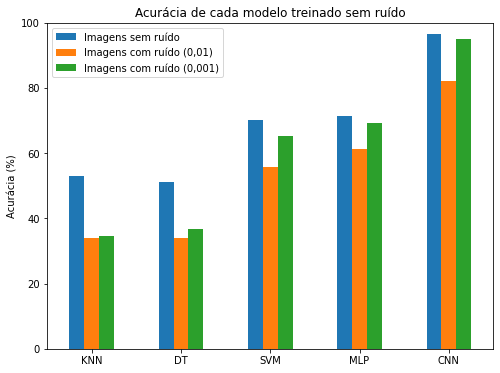

In [ ]:
plotRes('0')

*   Resultados obtidos no treinamento utilizando **com ruído de 0,01**:

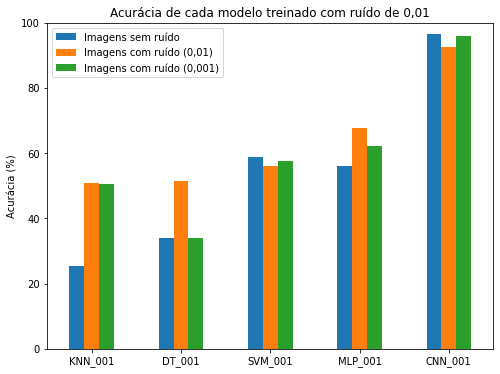

In [ ]:
plotRes('001')

*   Resultados obtidos no treinamento utilizando **com ruído de 0,001**:

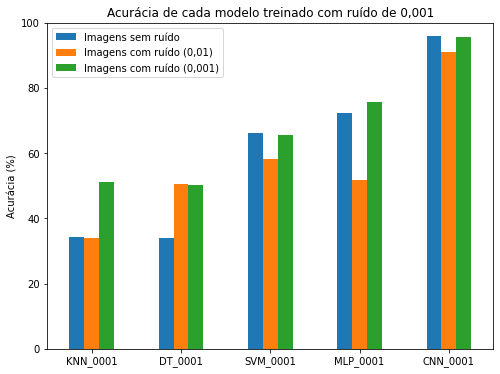

In [ ]:
plotRes('0001')

In [ ]:
pd.concat([df_mlp, df_mlp_001, df_mlp_0001, df_cnn, df_cnn_001, df_cnn_0001])

,Imagens sem ruído,"Imagens com ruído (0,01)","Imagens com ruído (0,001)"
MLP,0.713281,0.612891,0.691016
MLP_001,0.560937,0.677344,0.622266
MLP_0001,0.723047,0.516797,0.757422
CNN,0.963672,0.820703,0.950391
CNN_001,0.964063,0.926953,0.960547
CNN_0001,0.958594,0.911719,0.955859


# **Referências**:




* https://repositorio.unesp.br/bitstream/handle/11449/151042/padovese_bt_me_sjrp.pdf?sequence=3&isAllowed=y


* GAION, João Pedro de Barros Fernandes. Doença de Alzheimer: saiba mais sobre a principal causa de demência no mundo. saiba mais sobre a principal causa de demência no mundo. 2020. Disponível em: https://www.informasus.ufscar.br/doenca-de-alzheimer-saiba-mais-sobre-a-principal-causa-de-demencia-no-mundo/. Acesso em: 20 abr. 2022.


* ALZHEIMER'S ASSOCIATION. Alzheimer e demência no Brasil. 20--?. Disponível em: https://www.alz.org/br/demencia-alzheimer-brasil.asp. Acesso em: 20 abr. 2022.


* NAZARÉ, Thiago Santana de, et. al. Deep Convolutional Neural Networks and Noisy Images. Disponível em: https://sites.icmc.usp.br/moacir/papers/Nazare_CIARP2017_DNN-Noise.pdf. Acesso em: 22 abr. 2022.

* Modelo utilizado para a parte 3: https://ieeexplore.ieee.org/document/9215402